<h1 style="text-align:center;">Sentiment Analysis with Traditional Machine Learning</h1>

In [2]:
# to install required packages

# !pip install pandas numpy nltk scikit-learn xgboost imbalanced-learn
# !python.exe -m pip install --upgrade pip

In [3]:
import pandas as pd
import numpy as np
import os
import nltk
import string
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE

Functions

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

def load_dataset(path):
    """
    Load the dataset from the given path into a dataframe
    """
    reviews = []
    sentiments = []
    for label in ["pos", "neg"]:
        directory = os.path.join(path, label)
        for filename in os.listdir(directory):
            if filename.endswith(".txt"):
                with open(os.path.join(directory, filename), "r", encoding="utf-8") as file:
                    reviews.append(file.read())
                    sentiments.append(1 if label == "pos" else 0)
    return pd.DataFrame({"review": reviews, "sentiment": sentiments})

def preprocess_text(text):
    """
    Preprocess the text
    """
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

def evaluate_model(y_true, y_pred):
    """
    Evaluate the model
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Predict Sentiment of a Single Review
def predict_sentiment(review, model, vectorizer):
    cleaned_review = preprocess_text(review)
    review_vector = vectorizer.transform([cleaned_review]).toarray()
    prediction = model.predict(review_vector)
    return "Positive" if prediction[0] == 1 else "Negative"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sherj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sherj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading data and storing in csv format

In [5]:
# loading data from differnt text files
# train_data = load_dataset('data/aclImdb_v1/aclImdb/train')
# test_data = load_dataset('data/aclImdb_v1/aclImdb/test')

#save train and test data
# train_data.to_csv('data/train_data.csv', index=False)
# test_data.to_csv('data/test_data.csv', index=False)

In [6]:
#load train and test data from csv file
train_data = pd.read_csv('data/train_data.csv')
test_data = pd.read_csv('data/test_data.csv')

In [7]:
train_data.shape

(25000, 2)

In [8]:
test_data.shape

(25000, 2)

In [9]:
#preview train data
train_data.review[0]

'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!'

Preprocessing Data by removing 
- stop words
- punctuation
- lemmatization

In [10]:
# Removing stopwords
train_data['review'] = train_data['review'].apply(preprocess_text)
test_data['review'] = test_data['review'].apply(preprocess_text)


Checking balance of the classes in train and text data

<Axes: xlabel='sentiment'>

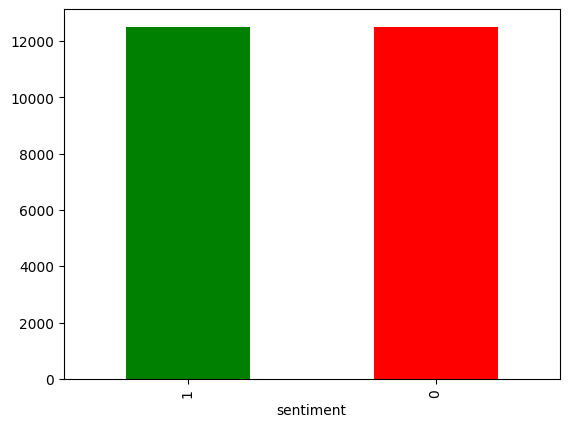

In [11]:
train_data['sentiment'].value_counts().plot(kind='bar', color=['green', 'red'])

<Axes: xlabel='sentiment'>

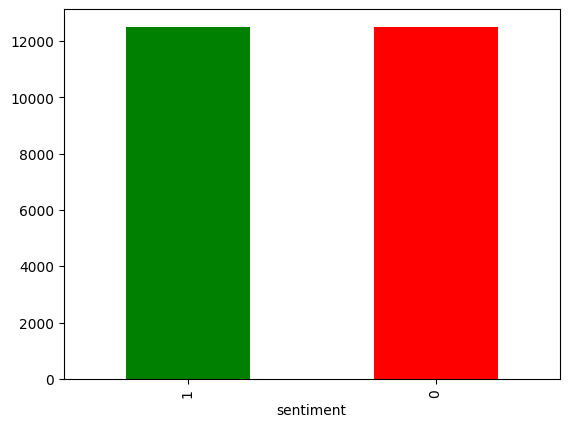

In [12]:
test_data['sentiment'].value_counts().plot(kind='bar', color=['green', 'red'])

Converting reviews into vectors and spliting ground truth in sperate arrays

In [13]:
# creating vectorizer from tex
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_data['review']).toarray()
X_test = vectorizer.transform(test_data['review']).toarray()

y_train = train_data['sentiment']
y_test = test_data['sentiment']


Training models (as all the classes are balanced so there is no need to catter Class Imbalance Handling techniques. but doing for the demonstration)

<p style="text-align:center;">Logistic Regression</p>

In [15]:
# Define the parameter grid
param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2']
}

# Initialize the Logistic Regression model
logreg = LogisticRegression(class_weight='balanced', max_iter=1000)

# Set up GridSearchCV
grid_search_logreg = GridSearchCV(estimator=logreg, param_grid=param_grid_logreg, cv=5, scoring='f1', verbose=2, n_jobs=5)

# Fit GridSearchCV
grid_search_logreg.fit(X_train, y_train)

# Best hyperparameters and score
best_logreg = grid_search_logreg.best_estimator_
best_logreg_params = grid_search_logreg.best_params_
best_logreg_score = grid_search_logreg.best_score_

print(f"Best Logistic Regression Parameters: {best_logreg_params}")
print(f"Best Logistic Regression Score: {best_logreg_score}")

# Predict using the best model
y_pred_logreg = best_logreg.predict(X_test)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Logistic Regression Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Logistic Regression Score: 0.8606137280133822


<p style="text-align:center;">SVM</p>


In [16]:
#class weights balanced to handle class imbalance as it give more weightage to minority class
svm = SVC(class_weight='balanced', gamma='auto', verbose=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

[LibSVM]

<p style="text-align:center;">XGBoost</p>

In [18]:
# using scale_pos_weight for handling class imbalancement
xgb = XGBClassifier(scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]))
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [ ]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Initialize the XGBClassifier model
xgb = XGBClassifier(scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]), use_label_encoder=False, tree_method='gpu_hist')

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='f1', verbose=3, n_jobs=5)

# Fit GridSearchCV
grid_search_xgb.fit(X_train, y_train)

# Best hyperparameters and score
best_xgb = grid_search_xgb.best_estimator_
best_xgb_params = grid_search_xgb.best_params_
best_xgb_score = grid_search_xgb.best_score_

print(f"Best XGBoost Parameters: {best_xgb_params}")
print(f"Best XGBoost Score: {best_xgb_score}")

# Predict using the best model
y_pred_xgb = best_xgb.predict(X_test)

Another sample technique to handle class imbalancement

In [ ]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Results

In [19]:
print("Logistic Regression Evaluation:")
evaluate_model(y_test, y_pred_logreg)

Logistic Regression Evaluation:
Accuracy: 0.8792
Precision: 0.8775
Recall: 0.8815
F1 Score: 0.8795

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [20]:
print("\nSupport Vector Machine Evaluation:")
evaluate_model(y_test, y_pred_svm)


Support Vector Machine Evaluation:
Accuracy: 0.7339
Precision: 0.6630
Recall: 0.9513
F1 Score: 0.7814

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.52      0.66     12500
           1       0.66      0.95      0.78     12500

    accuracy                           0.73     25000
   macro avg       0.79      0.73      0.72     25000
weighted avg       0.79      0.73      0.72     25000



In [21]:
print("\nXGBoost Evaluation:")
evaluate_model(y_test, y_pred_xgb)


XGBoost Evaluation:
Accuracy: 0.8536
Precision: 0.8404
Recall: 0.8730
F1 Score: 0.8564

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85     12500
           1       0.84      0.87      0.86     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



In [23]:
# Example prediction
review = "I really loved this movie! The acting was great and the story was thrilling."
print(predict_sentiment(review, best_logreg, vectorizer))

Positive
